# Overview
<p>Periodic loading of Peer to Peer financing data to an SQLite database. Operating for:
<br>--Mintos
<br>--IUVO
</p>

In [128]:
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3 as sql
import zipfile
import glob
import os

In [129]:
#Path to local Excel files containing the downloaded data from the P2P sites
path = "/home/hpiyankov/Documents/P2P/"

#Get the diretory with the latest downloads, we will use it also as date for the SQLite
dirList = [x[0] for x in os.walk(path)]
lastDir = max(dirList)
maxDate = lastDir[-10:]

print(lastDir)
print(maxDate)

/home/hpiyankov/Documents/P2P/2018-01-01
2018-01-01


# Mintos

## Loading data to dataframes

In [130]:
myZip = zipfile.ZipFile(lastDir+"/loan_book.zip","r")
contents = myZip.namelist()
print(*contents,sep="\n")

1-500000_loan_book.xlsx
500001-1000000_loan_book.xlsx
1000001-1500000_loan_book.xlsx
1500001-2000000_loan_book.xlsx
2000001-2500000_loan_book.xlsx


In [131]:
mintosDF = pd.DataFrame()

for m in contents:
    mintosDF = mintosDF.append(pd.read_excel(myZip.open(m,"r")))

mintosDF.shape

(2039464, 17)

In [132]:
#Let's make sure all is as expected
assert mintosDF.shape[0] > 100000
assert mintosDF.shape[1] == 17

In [133]:
#Drop spaces form column names for easier SQL storage
mintosDF.columns = [x.replace(" ","") for x in mintosDF.columns]
mintosDF["DATE"] = maxDate
mintosDF.head(5)

,Id,IssueDate,ListingDate,Country,LoanOriginator,LoanType,LoanRatePercent,Term,Collateral,InitialLTV,LTV,LoanStatus,Buybackreason,InitialLoanAmount,RemainingLoanAmount,Currency,Buyback,DATE
0,2014-1012,2014-10-17 00:00:00,2014-10-17 00:00:00,Latvia,Hipocredit,Mortgage Loan,14.2,60,Yes,13,6,Current,-,5000.0,2253.21,EUR,No,2018-01-01
1,17938-02,2016-02-02 00:00:00,2016-02-04 18:39:18,Latvia,Hipocredit,Mortgage Loan,15.4,60,Yes,45,41,Current,-,40525.0,36473.42,EUR,No,2018-01-01
2,2014-1003,2014-10-17 00:00:00,2014-10-17 00:00:00,Latvia,Hipocredit,Mortgage Loan,12.5,120,Yes,45,36,Late 1-15,-,30000.0,24354.30,EUR,No,2018-01-01
3,2014-10019,2014-10-10 00:00:00,2014-10-10 00:00:00,Latvia,Hipocredit,Mortgage Loan,13.6,120,Yes,60,49,Late 1-15,-,18000.0,14592.10,EUR,No,2018-01-01
4,2014-1002,2014-10-10 00:00:00,2014-10-10 00:00:00,Latvia,Hipocredit,Mortgage Loan,13.9,84,Yes,28,0,Finished prematurely,Not Specified,7700.0,0.00,EUR,No,2018-01-01


## Loading dataframe to SQLite DB

In [134]:
con = sql.connect(path+"Mintos_bup.db")
cur = con.cursor()

In [135]:
#Check what is currently there
mintosState = "SELECT DATE, count(*) FROM loan_book GROUP BY DATE ORDER BY 1 DESC;"
cur.execute(mintosState)
res = cur.fetchall()
print(res)

[('2018-01-01', 2039464), ('2017-12-01', 1864787), ('2017-11-05', 1720514)]


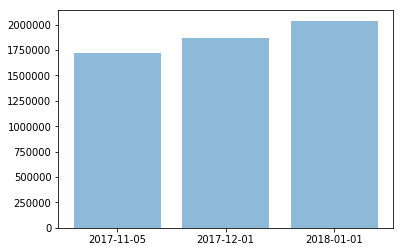

In [136]:
labels, values = zip(*res)
plt.bar(labels,values,width=0.8,align="center",alpha = 0.5)
    
plt.show()

In [137]:
print(maxDate)

2018-01-01


In [138]:
#Purge the date if it already exists
mintosPurge = "DELETE FROM loan_book WHERE DATE=?"
cur.execute(mintosPurge,(maxDate,))
cur.rowcount

2039464

In [139]:
#Add the new dataframe, there is some issues with append so make a seperate table
mintosDF.to_sql("loan_book_tmp",con,if_exists='replace')

In [140]:
#Insert data from temporaty table
mintosInsert = """
INSERT INTO LOAN_BOOK (`Id`,`IssueDate`,`ListingDate`,`Country`,`LoanOriginator`,`LoanType`,`LoanRatePercent`,`Term`,`Collateral`,`InitialLTV`,`LTV`,`LoanStatus`,`Buybackreason`,`InitialLoanAmount`,`RemainingLoanAmount`,`Currency`,`Buyback`,`DATE`)
SELECT `Id`,`IssueDate`,`ListingDate`,`Country`,`LoanOriginator`,`LoanType`,`LoanRatePercent`,`Term`,`Collateral`,`InitialLTV`,`LTV`,`LoanStatus`,`Buybackreason`,`InitialLoanAmount`,`RemainingLoanAmount`,`Currency`,`Buyback`,`DATE`
FROM loan_book_tmp;
"""
cur.execute(mintosInsert)
cur.execute("DROP TABLE IF EXISTS loan_book_temp")

#Fix the sequence table
cur.execute("DROP TABLE IF EXISTS date_sequence")

mintosFixSequence1 = """
CREATE TABLE tmp_date_sequence as 
	select 
		date, 
		(select count(*) from(select distinct date from LOAN_BOOK) as LB2 where LB2.date > LB1.date)+1 as seq 
	from (select distinct date from LOAN_BOOK) as LB1;
"""
mintosFixSequence2 = """
CREATE TABLE DATE_SEQUENCE as 
	select m.date as date1, e.date as date2, e.seq as seq2
	from tmp_date_sequence e inner join tmp_date_sequence m on e.seq = m.seq-1;
"""

cur.execute(mintosFixSequence1)
cur.execute(mintosFixSequence2)
cur.execute("DROP TABLE IF EXISTS tmp_date_sequence;")

In [141]:
con.commit()

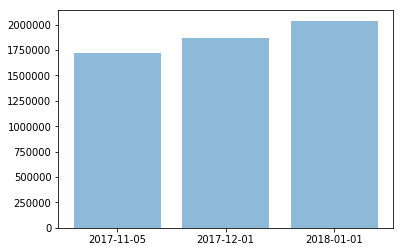

In [142]:
cur.execute(mintosState)
res = cur.fetchall()
labels, values = zip(*res)
plt.bar(labels,values,width=0.8,align="center",alpha = 0.5)
plt.show()

In [143]:
con.close()

# IUVO

## Loading data to dataframes

### Primary market

In [144]:
#Get the file, make sure it's only one
filepath=lastDir+"/Primary*.xlsx"
files = glob.glob(filepath)

assert len(files) == 1

In [145]:
iuvoPr = pd.read_excel(files[0],sheet_name="sheet1",skiprows=3)
iuvoPr.shape

(18254, 18)

In [146]:
#Let's make sure all is as expected
assert iuvoPr.shape[0] > 10000
assert iuvoPr.shape[1] == 18

In [147]:
iuvoPr.columns = [x.replace(" ","") for x in iuvoPr.columns]
iuvoPr["DATE"] = maxDate
iuvoPr.head(5)

,Country,ID,IssueDate,LoanType,AmortizationMethod,LoanOriginator,ScoreClass,GuaranteedofPrincipal(%),Currency,LoanAmount,RemainingPrincipal,InterestRate(%),Term,PaymentsReceived,InstalmentType,Status,AvailableforInvestment,MyInvestment,DATE
0,Bulgaria,185966,2017-07-17,Personal Loan,Full,EasyCredit,C,100,EUR,383.47,63.42,6.9671,2,11,14 days,current,11.67,-,2018-01-01
1,Bulgaria,219911,2017-11-09,Personal Loan,Full,EasyCredit,C,100,EUR,102.26,77.94,7.0605,3,1,30 days,current,12.44,-,2018-01-01
2,Bulgaria,211085,2017-10-20,Personal Loan,Full,EasyCredit,C,100,EUR,204.52,157.71,7.0591,6,2,30 days,current,13.48,-,2018-01-01
3,Bulgaria,209459,2017-10-18,Personal Loan,Full,EasyCredit,E,100,BGN,500.00,355.31,10.0041,9,4,14 days,3-15 days delay,14.63,-,2018-01-01
4,Romania,217318,2017-11-09,Personal Loan,Full,iCredit,B,100,EUR,129.25,74.79,7.2637,8,6,7 days,3-15 days delay,15.00,-,2018-01-01


### Secondary market

In [148]:
#Get the file, make sure it's only one
filepath=lastDir+"/Secondary*.xlsx"
files = glob.glob(filepath)

assert len(files) == 1

In [149]:
iuvoSec = pd.read_excel(files[0],sheet_name="sheet1",skiprows=3)
iuvoSec.shape

(622, 18)

In [150]:
#Let's make sure all is as expected
assert iuvoSec.shape[0] > 100
assert iuvoSec.shape[1] == 18

In [151]:
iuvoSec.columns = [x.replace(" ","") for x in iuvoSec.columns]
iuvoSec["DATE"] = maxDate
iuvoSec.head(5)

,Country,ID,IssueDate,LoanType,AmortizationMethod,LoanOriginator,ScoreClass,GuaranteedofPrincipal(%),InterestRate(%),Term,PaymentsReceived,InstalmentType,Status,Currency,AvailableforInvestment,Discount/Premium(%),Price,MyInvestment,DATE
0,Bulgaria,226492,2017-12-13,Personal Loan,Full,VivaCredit,HR,100,15.23,5,0,30 days,current,EUR,15.00,15.23,17.28,-,2018-01-01
1,Bulgaria,226444,2017-12-13,Personal Loan,Full,VivaCredit,HR,100,15.23,5,0,30 days,current,EUR,11.06,15.23,12.74,-,2018-01-01
2,Bulgaria,226483,2017-12-12,Personal Loan,Full,VivaCredit,HR,100,15.22,3,0,30 days,current,EUR,24.00,15.22,27.65,-,2018-01-01
3,Bulgaria,226339,2017-12-11,Personal Loan,Full,VivaCredit,E,100,12.34,3,0,30 days,current,EUR,12.80,2.99,13.18,-,2018-01-01
4,Bulgaria,226347,2017-12-11,Personal Loan,Full,VivaCredit,HR,100,15.22,3,0,30 days,current,EUR,24.00,15.22,27.65,-,2018-01-01


## Loading dataframe to SQLite DB

In [152]:
con = sql.connect(path+"IUVO_bup.db")
cur = con.cursor()

In [153]:
#Check what is currently there
iuvoState = """
SELECT a.DATE, a.PM, b.SM
    FROM 
        (SELECT DATE, count(*) as PM FROM IUVO_PM GROUP BY DATE) a
    LEFT JOIN 
        (SELECT DATE, count(*) as SM FROM IUVO_SM GROUP BY DATE) b ON a.DATE = b.DATE
ORDER by 1 desc;
"""
cur.execute(iuvoState)
res = cur.fetchall()
print(res)

[('2018-01-01', 18254, 622), ('2017-12-01', 22589, 621), ('2017-11-05', 15885, 693)]


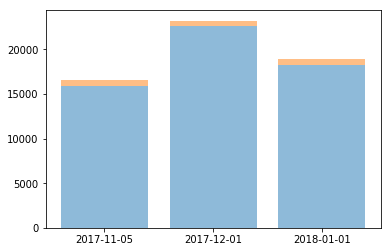

In [154]:
labels, PM, SM = zip(*res)
plt.bar(labels,PM,width=0.8,align="center",alpha = 0.5)
plt.bar(labels,SM,width=0.8,align="center",alpha = 0.5, bottom=PM)

plt.show()

In [155]:
print(maxDate)

2018-01-01


### Primary Market

In [156]:
#Purge the date if it already exists
PMPurge = "DELETE FROM IUVO_PM WHERE DATE=?"
cur.execute(PMPurge,(maxDate,))
cur.rowcount

18254

In [157]:
#Add the new dataframe, there is some issues with append so make a seperate table
iuvoPr.to_sql("PM_tmp",con,if_exists='replace')

In [158]:
#Insert data from temporaty table
PMInsert = """
INSERT INTO IUVO_PM (`Country`,`ID`,`IssueDate`,`LoanType`,`AmortizationMethod`,`LoanOriginator`,`ScoreClass`,`GuaranteedofPrincipal(%)`,`Currency`,`LoanAmount`,`RemainingPrincipal`,`InterestRate(%)`,`Term`,`PaymentsReceived`,`InstalmentType`,`Status`,`AvailableforInvestment`,`MyInvestment`,`DATE`)
SELECT `Country`,`ID`,`IssueDate`,`LoanType`,`AmortizationMethod`,`LoanOriginator`,`ScoreClass`,`GuaranteedofPrincipal(%)`,`Currency`,`LoanAmount`,`RemainingPrincipal`,`InterestRate(%)`,`Term`,`PaymentsReceived`,`InstalmentType`,`Status`,`AvailableforInvestment`,`MyInvestment`,`DATE`
FROM PM_tmp;
"""
cur.execute(PMInsert)
cur.execute("DROP TABLE IF EXISTS PM_tmp")

### Secondary Market

In [159]:
#Purge the date if it already exists
SMPurge = "DELETE FROM IUVO_SM WHERE DATE=?"
cur.execute(SMPurge,(maxDate,))
cur.rowcount

622

In [160]:
#Add the new dataframe, there is some issues with append so make a seperate table
iuvoSec.to_sql("SM_tmp",con,if_exists='replace')

In [161]:
#Insert data from temporaty table
SMInsert = """
INSERT INTO IUVO_SM (`Country`,`ID`,`IssueDate`,`LoanType`,`AmortizationMethod`,`LoanOriginator`,`ScoreClass`,`GuaranteedofPrincipal(%)`,`InterestRate(%)`,`Term`,`PaymentsReceived`,`InstalmentType`,`Status`,`XIRR(%)`,`Currency`,`AvailableforInvestment`,`Discount/Premium(%)`,`Price`,`MyInvestment`,`Date`)
SELECT `Country`,`ID`,`IssueDate`,`LoanType`,`AmortizationMethod`,`LoanOriginator`,`ScoreClass`,`GuaranteedofPrincipal(%)`,`InterestRate(%)`,`Term`,`PaymentsReceived`,`InstalmentType`,`Status`,'',`Currency`,`AvailableforInvestment`,`Discount/Premium(%)`,`Price`,`MyInvestment`, `DATE`
FROM SM_tmp;
"""
cur.execute(SMInsert)
cur.execute("DROP TABLE IF EXISTS SM_tmp")

### Cross-checks

In [162]:
con.commit()

In [163]:
#Check what is currently there
iuvoState = """
SELECT a.DATE, a.PM, b.SM
    FROM 
        (SELECT DATE, count(*) as PM FROM IUVO_PM GROUP BY DATE) a
    LEFT JOIN 
        (SELECT DATE, count(*) as SM FROM IUVO_SM GROUP BY DATE) b ON a.DATE = b.DATE
ORDER by 1 desc;
"""
cur.execute(iuvoState)
res = cur.fetchall()
print(res)

[('2018-01-01', 18254, 622), ('2017-12-01', 22589, 621), ('2017-11-05', 15885, 693)]


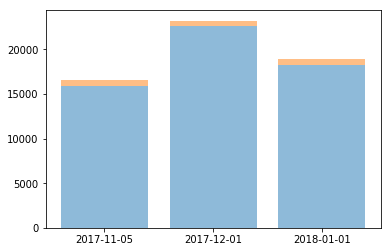

In [164]:
labels, PM, SM = zip(*res)
plt.bar(labels,PM,width=0.8,align="center",alpha = 0.5)
plt.bar(labels,SM,width=0.8,align="center",alpha = 0.5, bottom=PM)

plt.show()

In [165]:
con.close()